## Small Dataset Full-Image Species Exploration 

In this notebook, we explore a small portion of Haiti Tree Project (THTP) captures labeled by Cam. These are full images and represent a small portion of the dataset (hence small). This notebook is for transfer learning using a pretrained Inception v3 classifier, same as that used by Pl@ntNet.


### Dependencies

In [43]:
import torch
import numpy as np
import pandas as pd
import os
import sklearn
from sklearn.metrics import confusion_matrix
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import urllib
import time

from PIL import Image

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import torchvision.models as models
from torchvision.io import read_image
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader


import requests
import json


torch.backends.cudnn.benchmark = True

### Data Retrieval
 
 
For now, download each image/label pair Cam has specified ([Github link](https://gconfusion_matrixcom/Greenstand/Tree_Species/tree/master/training)).

In [44]:
datadir = "/home/ec2-user/SageMaker/treetracker-machine-learning/sample_datasets/Haiti/cam_training.psv"
baseurl = "https://treetracker-production-images.s3.eu-central-1.amazonaws.com/"
assert os.path.exists(datadir)
data = pd.read_csv(datadir, sep="|", header=None)
data.columns = ["class", "imname"]
data["url"] = baseurl + data["imname"]
data.head(5)

,class,imname,url
0,ACACAURI,2020.11.29.12.18.36_18.285143729299307_-73.564...,https://treetracker-production-images.s3.eu-ce...
1,ACACAURI,2020.11.29.12.18.59_18.285102993249893_-73.564...,https://treetracker-production-images.s3.eu-ce...
2,ACACAURI,2020.11.29.12.47.34_18.290133895352483_-73.557...,https://treetracker-production-images.s3.eu-ce...
3,ACACAURI,2020.11.29.12.47.48_18.29019017983228_-73.5579...,https://treetracker-production-images.s3.eu-ce...
4,ACACAURI,2020.11.29.12.50.51_18.29083981923759_-73.5582...,https://treetracker-production-images.s3.eu-ce...


In [45]:
savepath = "/home/ec2-user/SageMaker/treetracker-machine-learning/sample_datasets/Haiti/"
for species in data["class"].unique():
    if not os.path.exists(os.path.join(savepath, species)):
        os.makedirs(os.path.join(savepath, species))
        
def image_saver(df):
    try:
        urllib.request.urlretrieve(df["url"], os.path.join(savepath, df["class"], df["imname"]))
        return True
    except:
        return False
    
        
# image_saver = lambda df: urllib.request.urlretrieve(df["url"], os.path.join(savepath, df["class"], df["imname"]))
data["saved"] = data.apply(image_saver, axis=1)
print (data[data["saved"]].shape[0], " images saved out of ", data.shape[0])

710  images saved out of  772


710  total valid samples
Class breakdown
{'ACACAURI': 130, 'ANACOCCI': 86, 'CATALONG': 100, 'CEDRODOR': 113, 'MANGINDI': 221, 'SIMAGLAU': 60}
6  classes found


Text(0.5, 1.0, 'Count per class')

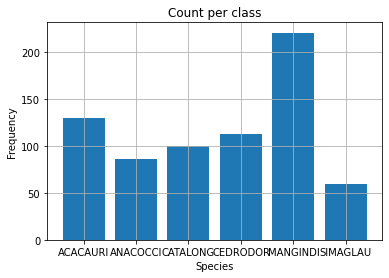

In [46]:
data = data[data["saved"]]
print (data.shape[0], " total valid samples")
print ("Class breakdown")
count_by_class = data.groupby("class").aggregate("count")
baseline_acc = np.max
print (dict(zip(count_by_class.index, count_by_class.values[:, 0])))
num_classes = data["class"].unique().shape[0]
print (num_classes, " classes found")
plt.bar(count_by_class.index, count_by_class["imname"])
plt.grid()
plt.xlabel("Species")
plt.ylabel("Frequency")
plt.title("Count per class")

In [47]:
arrs = []
labels = []
import logging 
# You must initialize logging, otherwise you'll not see debug output.
logging.basicConfig()
logging.getLogger().setLevel(logging.WARNING)

for species in data["class"].unique():
    for img in os.listdir(os.path.join(savepath, species)):
        if os.path.splitext(os.path.join(savepath, species, img))[1].lower() in [".jpg", ".png"]:
            arrs.append(Image.open(os.path.join(savepath, species, img)).resize((299, 299)))
            labels.append(species)
            


## Visualize a few images, explore features



Populating the interactive namespace from numpy and matplotlib


/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['scatter', 'median', 'laplace', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


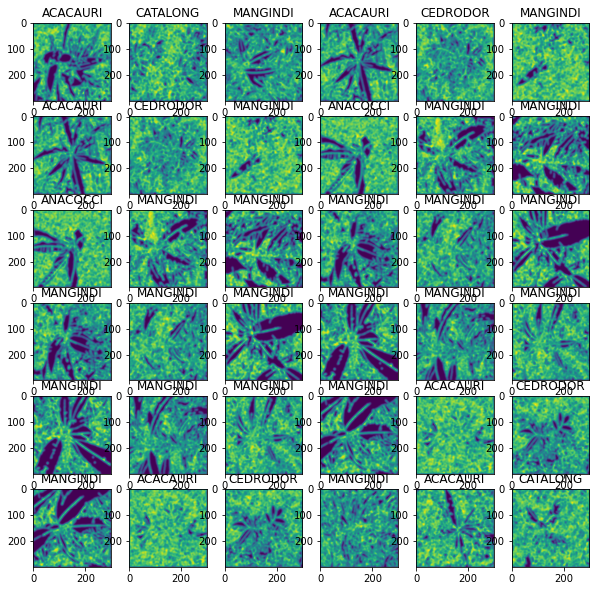

In [48]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import feature
from skimage.color import rgb2gray
from skimage.filters import * 
n_imgs = 36
idxs = np.random.choice(np.arange(0, len(arrs)), replace=False, size=n_imgs)
f, axarr = plt.subplots(6, 6, figsize=(10 ,10))

preprocessing = lambda img: gaussian(feature.canny(rgb2gray(np.array(img)), sigma=1), 3)
preprocess = []
for i in range(6):
    for j in range(6):
        idx = idxs[i * 3 + j]
        img = np.array(arrs[idx])[:, :, 1]
        # axarr[i, j].imshow(feature.canny(rgb2gray(np.array(arrs[idx]))))
        axarr[i, j].imshow(preprocessing(img))
        axarr[i, j].set_title(labels[idx])
plt.show()
    

In [29]:
X = np.vstack([preprocessing(img).flatten() for img in arrs])
pca = PCA(n_components=50)
X_red = pca.fit_transform(X)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_ * 100))
print (np.sum(pca.explained_variance_ratio_) * 100 , "% variance explained total")

Explained variation per principal component: [13.99854449  3.27726314  2.56898466  1.95173601  1.70075119  1.63370437
  1.35395942  1.25956466  1.06057259  1.03761913  0.97739445  0.91785919
  0.89224436  0.84608626  0.77818329  0.76520139  0.74297236  0.71324951
  0.68872275  0.6584491   0.63813943  0.61976227  0.60275791  0.59188381
  0.55911553  0.55116217  0.53958509  0.52419979  0.515678    0.50828695
  0.49265935  0.47449615  0.47168573  0.44535041  0.43178572  0.42807496
  0.42429596  0.41472518  0.40418175  0.39419367  0.38952475  0.37947095
  0.37706502  0.36898595  0.36289852  0.35832857  0.35570056  0.34828339
  0.34262396  0.33200158]
51.46996540669144 % variance explained total


In [49]:
X_embedded = TSNE(n_components=2, perplexity=80.0, learning_rate=24.0, n_iter=10000).fit_transform(X_red)
tsne_result = pd.DataFrame(X_embedded)
tsne_result["class"] = labels
tsne_result.columns = ["x0", "x1", "class"]
colors = np.linspace(0, 1, len(data["class"].unique()))
colordict = dict(zip(data["class"].unique(), colors))  
tsne_result["Color"] = tsne_result["class"].apply(lambda x: colordict[x])

In [50]:
print (tsne_result.head(5))

         x0        x1     class  Color
0  6.464226 -6.943143  ACACAURI    0.0
1  8.381555 -5.228263  ACACAURI    0.0
2  7.042583 -5.805161  ACACAURI    0.0
3  4.384457 -6.240985  ACACAURI    0.0
4 -5.211196  0.510385  ACACAURI    0.0


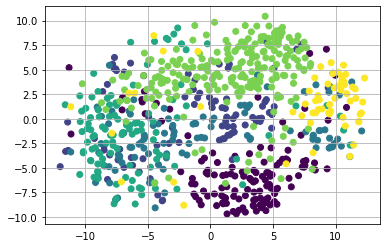

In [51]:
plt.grid()
plt.scatter(tsne_result["x0"], tsne_result["x1"], c=tsne_result["Color"], label=tsne_result["class"])


## Prepare dataset for training

In [52]:
class HaitiDataset(torch.utils.data.Dataset):
    def __init__(self, df, loadpath, transform, encoding):
        '''
        A dataset with image names, classes, and a provided loading path to load images from
        '''
        self.loadpath = loadpath
        self.data = df
        self.n_classes = self.data["class"].unique().shape[0]
        self.transform = transform
        self.numerical_encoding = dict(zip(sorted(list(self.data["class"].unique())), list(range(self.n_classes))))
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.loadpath, self.data.iloc[idx, :]["class"], self.data.iloc[idx, :]["imname"])
        label = self.data.iloc[idx, :]["class"]
        img = self.transform(Image.open(img_path))
        label = self.numerical_encoding[label]
        return img, label
        
    def make_class_weighting(self):
        count_by_class = data.groupby("class").aggregate("count") 
        count_by_class = count_by_class / count_by_class.sum()
        count_by_class.index = count_by_class.index.map(self.numerical_encoding)
        return count_by_class.values[:, 0]


In [53]:
val_split = 0.3
num_epochs = 1000

idxs = np.arange(data.shape[0])
np.random.shuffle(idxs)

transform = T.Compose([T.Resize(512), 
                       T.CenterCrop(299), # need center 299 pixel for Inception v3 feature extractor
                       T.RandomRotation(degrees=90),
                       T.RandomHorizontalFlip(p=0.5), 
                       T.ColorJitter(), 
                       T.ToTensor(),
                       T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                      ])


tr_idxs = idxs[:int (val_split * data.shape[0]), ...]
val_idxs = idxs[int (val_split * data.shape[0]):, ...]

tr_dataset = HaitiDataset(data.iloc[tr_idxs, :], savepath, transform, None)
val_dataset = HaitiDataset(data.iloc[val_idxs, :], savepath, transform, None)

tr_dataloader = DataLoader(tr_dataset, batch_size=64, shuffle=True, num_workers=1, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=val_idxs.shape[0], shuffle=True, num_workers=1, pin_memory=True)



In [71]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
def predictor_helper(df, model, preprocess):
    path =  os.path.join(savepath, df["class"], df["imname"])
    img = Image.open(path)
    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    model.eval()
    with torch.no_grad():
        output = model(input_batch)
    return output.squeeze().numpy()

In [62]:
def feature_tsne(model, data, fv_col, pca_ndims=100):
    model_stack = np.vstack([fv for fv in data[fv_col].values])
    pca = PCA(n_components=pca_ndims)
    X_red = pca.fit_transform(inception_stack)
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_ * 100))
    print (np.sum(pca.explained_variance_ratio_) * 100 , "% variance explained total")
    model_embedding = TSNE(n_components=2, perplexity=80.0, learning_rate=20.0, n_iter=15000).fit_transform(X_red)
    tsne_model_result = pd.DataFrame(model_embedding)
    tsne_model_result["class"] = labels
    tsne_model_result.columns = ["x0", "x1", "class"]

    # Make figure
    f = plt.figure(figsize=(20, 10))
    scatter = plt.scatter(tsne_model_result["x0"], tsne_model_result["x1"], c=tsne_model_result["class"].astype('category').cat.codes)
    plt.title("t-SNE of %d Haiti Species %s"%(num_classes, fv_col))
    plt.grid()
    plt.legend(handles=scatter.legend_elements()[0],
               labels=list(tsne_model_result["class"].astype('category').cat.categories),
               title="species",
               bbox_to_anchor=(1.2,0.75),
               loc='right')
    plt.show()

In [58]:
def train_model(model, criterion, tr_dataloader, val_dataloader, num_epochs=100):
    torch.cuda.empty_cache()
    for epoch in range(num_epochs):
        running_loss = 0
        start = time.time()
        tr_acc_sum = 0
        tr_samples = 0
        n_tr_batches = 0
        for batch_x, batch_y in tr_dataloader:
            n_tr_batches += 1
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            optimizer.zero_grad()
            output = model.forward(batch_x)
            loss = criterion(output.logits, batch_y)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            tr_acc_sum += torch.sum(torch.argmax(output.logits, dim=1) == batch_y)
            tr_samples += batch_y.size()[0]
        cf_matx = None
        with torch.no_grad():
            n_val_batches = 0
            val_samples = 0
            running_val_loss = 0
            val_acc_sum = 0
            for val_x, val_y in val_dataloader:
                n_val_batches += 1
                val_x = val_x.to(device)
                val_y = val_y.to(device)
                val_output = model.forward(val_x)
                val_loss = criterion(val_output.logits, val_y)
                running_val_loss += val_loss.item()
                preds = torch.argmax(val_output.logits, dim=1)
                val_acc_sum += torch.sum(preds == val_y) # wrote this way just in case there's batched validation
                val_samples += val_y.size()[0]
                cf_matx = confusion_matrix(preds.detach().cpu().numpy(), val_y.detach().cpu().numpy())
        print ("Epoch %d finished in %f seconds"%(epoch + 1, time.time() - start))
        print ("Training/Validation Loss per Batch: %f/ %f"%(running_loss / n_tr_batches, running_val_loss / n_val_batches))
        print ("Training/Validation Accuracy (percent): %f /%f"%(100 * tr_acc_sum / tr_samples, 100 * val_acc_sum / val_samples))
        print ("Confusion matrix:")
        print (cf_matx)
        print ("=" * 40)
    print ("Finished training")

Explained variation per principal component: [18.414446   10.050885    7.458213    6.59511     4.0729294   2.6407263
  2.32699     2.1053898   1.9214481   1.8119653   1.5711808   1.4686421
  1.35572     1.3052975   1.2448168   1.1686368   1.0160601   1.0084285
  0.94523764  0.88717246  0.7903535   0.77463615  0.7107674   0.68530315
  0.6332601   0.61196715  0.5826532   0.56392205  0.5595651   0.551386
  0.5293035   0.5069503   0.49923897  0.47912532  0.45855838  0.4364131
  0.41794804  0.4059772   0.38445887  0.3821413   0.37792355  0.34961328
  0.34438822  0.33574596  0.3203881   0.3165284   0.30941537  0.29528818
  0.28875077  0.283004    0.2746905   0.26952252  0.26366004  0.25926253
  0.25623327  0.25316426  0.24344462  0.23640679  0.23150933  0.22786765
  0.22497971  0.22398768  0.21987815  0.20962982  0.2059636   0.20275009
  0.1986597   0.19262224  0.18641677  0.1842358   0.17976646  0.17465658
  0.17328411  0.16894393  0.1622107   0.16192     0.15644473  0.15471141
  0.15151173

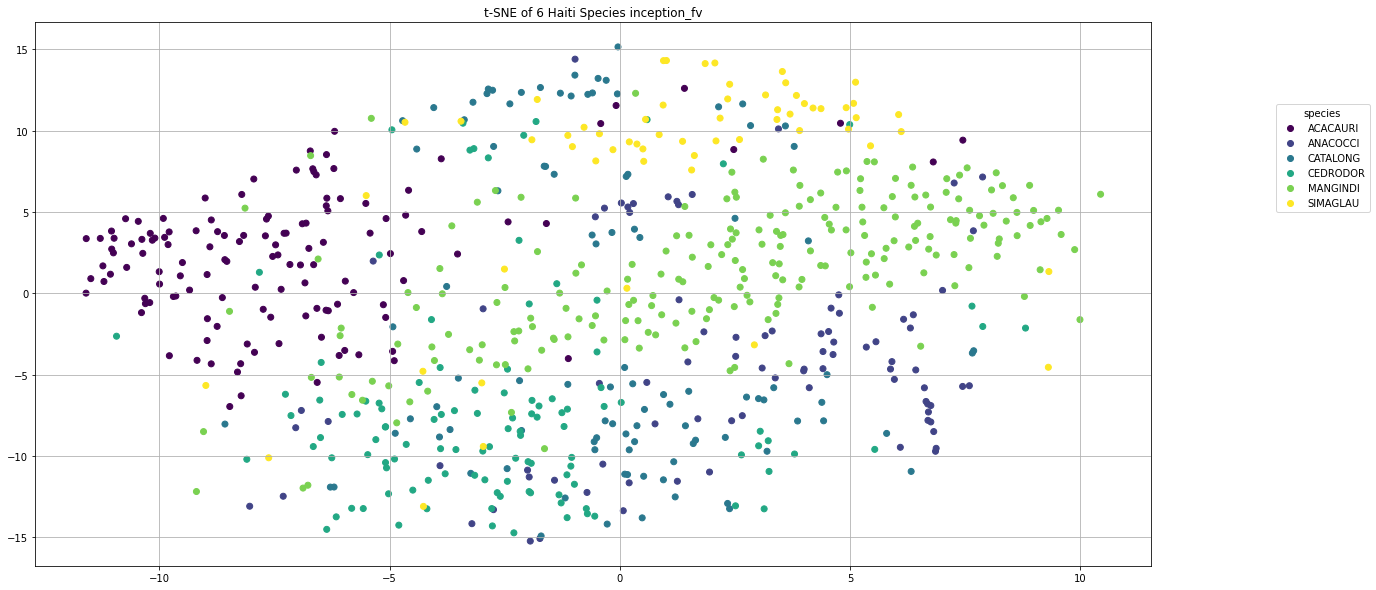

Device:  cuda:0
[Parameter containing:
tensor([[-0.0064, -0.0119, -0.0300,  ..., -0.0233, -0.0152, -0.0082],
        [-0.0265, -0.0162, -0.0148,  ...,  0.0115, -0.0355, -0.0280],
        [-0.0331,  0.0168, -0.0097,  ..., -0.0139,  0.0080,  0.0112],
        [-0.0291, -0.0327,  0.0085,  ...,  0.0111,  0.0175,  0.0357],
        [-0.0047,  0.0078,  0.0014,  ...,  0.0098, -0.0295, -0.0325],
        [ 0.0267, -0.0138,  0.0202,  ...,  0.0218,  0.0155, -0.0058]],
       requires_grad=True), Parameter containing:
tensor([ 0.0344, -0.0360, -0.0321, -0.0358,  0.0138, -0.0251],
       requires_grad=True), Parameter containing:
tensor([[-0.0063,  0.0024,  0.0171,  ..., -0.0138,  0.0048, -0.0002],
        [ 0.0112, -0.0031,  0.0215,  ..., -0.0215, -0.0023,  0.0202],
        [-0.0042,  0.0195, -0.0092,  ..., -0.0131,  0.0067, -0.0096],
        [ 0.0106,  0.0127, -0.0120,  ..., -0.0101,  0.0185,  0.0114],
        [-0.0135,  0.0160,  0.0052,  ..., -0.0189,  0.0046, -0.0208],
        [ 0.0167,  0.0070, 

In [72]:
inception = models.inception_v3(pretrained=True)
set_parameter_requires_grad(inception, feature_extracting=True) 
inception_ft_preprocess = T.Compose([
    T.Resize(299),
    T.CenterCrop(299),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
data['inception_fv'] = data.apply(predictor_helper, axis=1, model=inception, preprocess=inception_ft_preprocess)
feature_tsne(inception, data, 'inception_fv', 100)
num_ftrs = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = torch.nn.Linear(num_ftrs, num_classes)
# Handle the primary net
num_ftrs = inception.fc.in_features
inception.fc = torch.nn.Linear(num_ftrs,num_classes)

params_to_update = []
for name, param in inception.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ("Device: ", device)
print (params_to_update)
class_weights = tr_dataset.make_class_weighting()
criterion = torch.nn.CrossEntropyLoss(reduction="mean", weight=torch.Tensor(class_weights)).cuda()
inception = inception.to(device)
inception.train()
optimizer = torch.optim.Adam(params_to_update, lr=1e-3, weight_decay=1e-4)


In [ ]:
train_model(inception, criterion, tr_dataloader, val_dataloader, 100)

In [ ]:
resnet = models.resnet18(pretrained=True)
resnet_ft_preprocess = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
data['resnet_fv'] = data.apply(predictor_helper, axis=1, model=resnet, preprocess=resnet_ft_preprocess)
set_parameter_requires_grad(resnet, feature_extracting=True)
feature_tsne(inception, data, 'resnet_fv', 100)
resnet.fc = torch.nn.Linear(resnet.fc.in_features, num_classes)
